In [1]:
import sys
import IPython.display

In [2]:
sys.path.insert(0, "/home/mai/zkhan/ALBEF")

In [80]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor, resize
from PIL import Image, ImageDraw, ImageFont
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
from models.tokenization_bert import BertTokenizer
from models.single_stream.pretrain_with_mlm import ALBEF

In [5]:
import json
import random
import ruamel.yaml as yaml
from wordcloud import WordCloud
from nltk.corpus import wordnet as wn
import spacy

In [6]:
nlp = spacy.load('en_core_web_sm')

In [7]:
from dataset.utils import pre_caption

In [8]:
with open('/net/acadia10a/data/zkhan/cc12m-json/100k.json', 'r') as f:
    cc100k = json.load(f)

In [9]:
normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
test_transform = transforms.Compose([
        transforms.Resize((256,256),interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        normalize,
])

view_transform = transforms.Compose([
        transforms.Resize((256,256),interpolation=Image.BICUBIC),
        transforms.ToTensor(),
])



with open('../configs/singlestream/Pretrain4M_baseline.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.Loader)
# patch the BERT config to be an absolute path because we're running
# the code from a different directory
config['bert_config'] = '/home/mai/zkhan/ALBEF/configs/config_bert_singlestream.json'

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = ALBEF(config=config, text_encoder='bert-base-uncased', tokenizer=tokenizer, init_deit=True)
checkpoint = torch.load(
    '/net/acadia10a/data/zkhan/ALBEF-checkpoints/singlestream/pretrain4m_with_mlm/checkpoint_10.pth',
    map_location='cpu'
)
state_dict = checkpoint['model']
model.load_state_dict(state_dict)

device = torch.device('cuda')
model.eval();
model = model.to(device)

/home/mai/zkhan/miniconda3/envs/ssl/lib/python3.7/site-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


reshape position embedding from 196 to 256
_IncompatibleKeys(missing_keys=[], unexpected_keys=['head.weight', 'head.bias'])


In [10]:
word_embeddings = F.normalize(model.text_encoder.bert.embeddings.word_embeddings.weight, dim=1)

Exploring the World of Astronomy


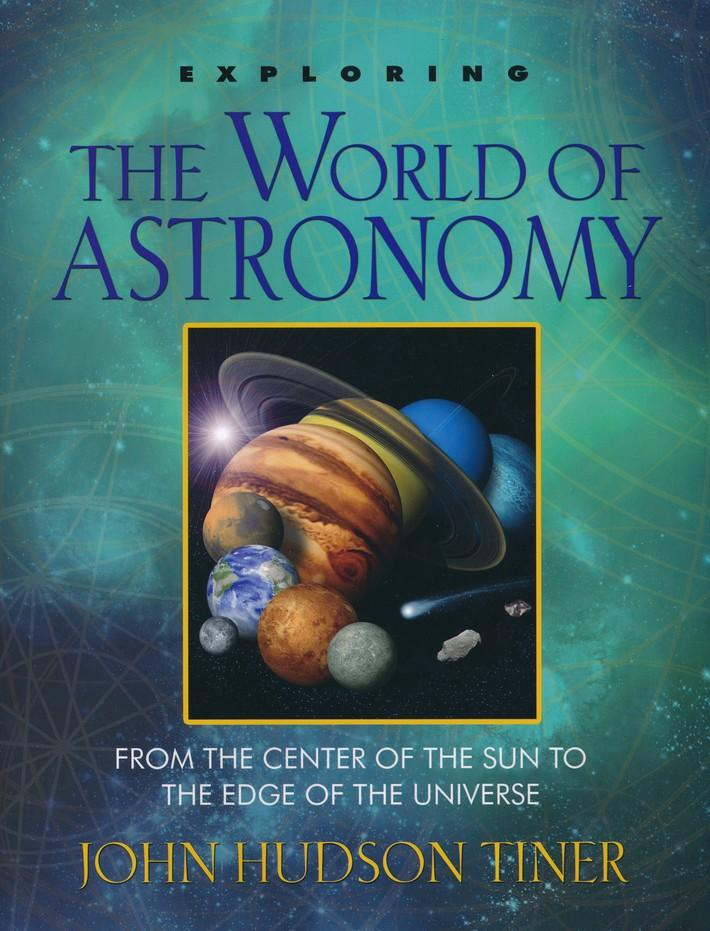

In [204]:
sample = random.choice(cc100k)
print(sample['caption'])
IPython.display.Image(sample['image'], width=300)

In [205]:
image = test_transform(Image.open(sample['image']).convert('RGB'))
view_image = view_transform(Image.open(sample['image']).convert('RGB'))

In [206]:
caption = pre_caption(sample['caption'], 30)
caption

'exploring the world of astronomy'

In [207]:
image = image.to(device)

In [208]:
text = tokenizer(caption, padding='longest', truncation=True, max_length=25, return_tensors="pt").to(device)

In [209]:
image_embeds = model.visual_encoder(image.unsqueeze(0)).squeeze()
image_embeds = F.normalize(image_embeds, dim=1)
image_embeds.shape

torch.Size([257, 768])

In [210]:
image_atts = torch.ones(image_embeds.shape[:-1])
image_atts.shape

torch.Size([257])

In [211]:
def make_sentence_pair(model, text_token_ids, text_attn_mask, image_embeds, image_atts, device):
        text_token_ids = text_token_ids.clone()
        with torch.no_grad():
            text_token_ids[:, 0] = model.tokenizer.sep_token_id 
        # Create the [CLS] prefix for the visual token. 
        # prefix = torch.zeros(image_embeds.shape[0], 1).to(image.device) * self.tokenizer.cls_token_id
        # prefix = prefix.long()
        # prefix_embeds = self.text_encoder.bert.embeddings.word_embeddings(prefix)
        # Get the word embeddings for language.
        word_embeddings = model.text_encoder.bert.embeddings.word_embeddings(text_token_ids)
        # Concatenate it all to make the input sentence.
        mm_model_input = torch.cat([image_embeds, word_embeddings], dim=1)
        # Create the attention mask for the combined sentence.
        print(image_atts.shape, text_attn_mask.shape)
        imtext_attention_mask = torch.cat([image_atts, text_attn_mask], dim=1) 
        # Get the token_type_ids.
        # Following the BERT convention, the token_type_ids for the first sentence is 0,
        # and the second sentence is 1. To achieve this, we can simply concatenate the attention mask
        # of the text with a zero tensor.
        text_token_type_ids = text_attn_mask.clone()
        with torch.no_grad():
            text_token_type_ids[:, 0] = 0 # the [SEP] between the sentences is considered as sentence B.
        token_type_ids = torch.cat([torch.zeros_like(image_atts).to(device), text_token_type_ids], dim=1)
        return mm_model_input, imtext_attention_mask, token_type_ids

In [212]:
sentence, attn_mask, token_type_ids = make_sentence_pair(model, text.input_ids, text.attention_mask, image_embeds.unsqueeze(0).cuda(), 
                   image_atts.unsqueeze(0).cuda(), device)

torch.Size([1, 257]) torch.Size([1, 6])


In [213]:
with torch.no_grad():
    model_output = model.text_encoder.bert(
        inputs_embeds=sentence, 
        attention_mask=attn_mask.long(),
        token_type_ids=token_type_ids.long(), 
        return_dict=True, mode='text', output_attentions=True
    )

In [214]:
len(model_output.attentions)

12

In [215]:
model_output.attentions[0].shape

torch.Size([1, 12, 263, 263])

<BarContainer object of 263 artists>

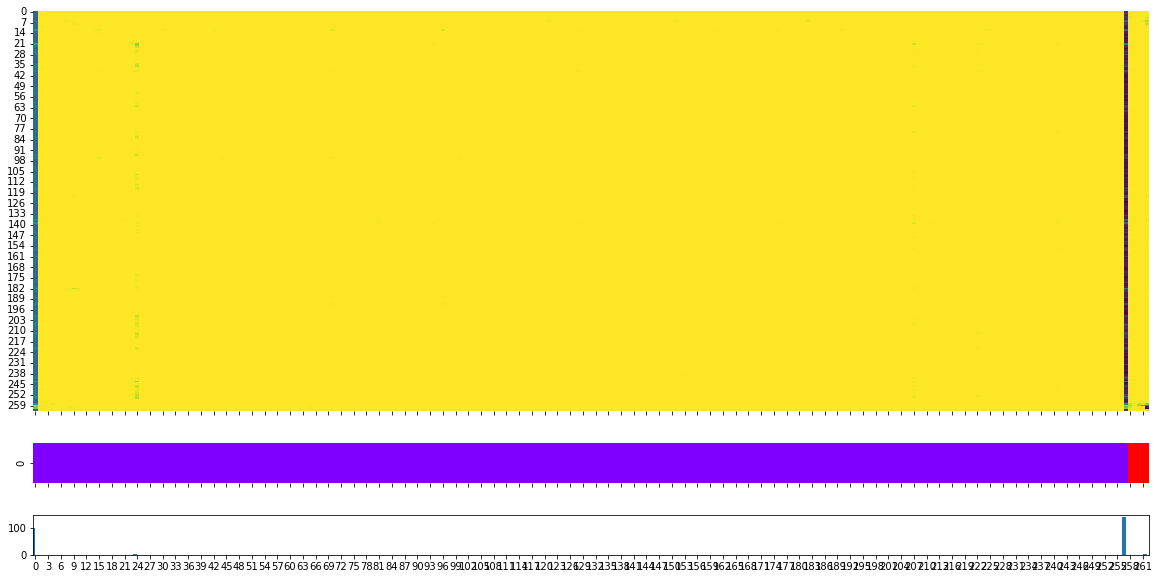

In [216]:
head = 5
level = 0
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': (10, 1, 1)})
sns.heatmap(model_output.attentions[head].squeeze()[level].cpu().numpy(), ax=ax1, cbar=False, cmap='viridis_r')
sns.heatmap(token_type_ids.cpu().numpy(), ax=ax2, cbar=False, cmap='rainbow')
ax3.bar(np.arange(token_type_ids.shape[-1]), model_output.attentions[head].squeeze()[level].cpu().numpy().sum(axis=0))

In [217]:
vit_cls = F.normalize(image_embeds, dim=1)[0]
sims = vit_cls @ word_embeddings.T
_, closest_lang_embeds = sims.topk(10)
closest_words = tokenizer.decode(list(closest_lang_embeds.cpu().numpy())).split()
print(closest_words)

['capital', 'location', 'picture', 'scarce', 'ex', 'setting', 'example', 'walk', 'situation', 'photograph']


Text(0.5, 1.0, 'Patches closest to comet')

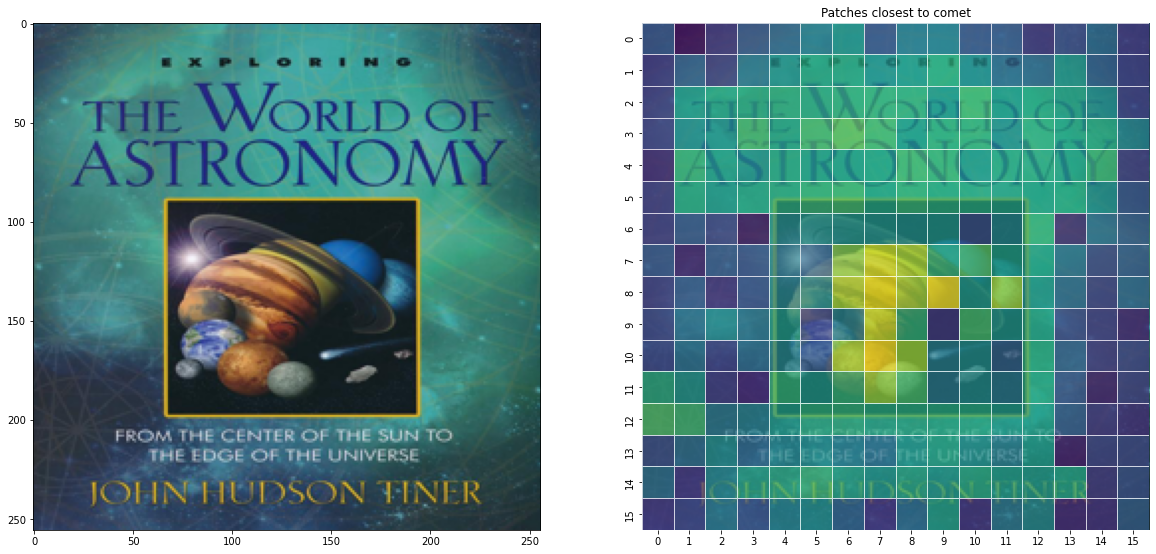

In [293]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
literal_word = 'comet'
search_word = word_embeddings[tokenizer.encode(literal_word)[-1]]
sim_map = (search_word @ F.normalize(image_embeds, dim=1).T).detach().cpu().numpy()[1:].reshape(16, 16)
sns.heatmap(sim_map, cbar=False, ax=ax2, zorder=5, linewidths=.5, alpha=.7, cmap='viridis')
ax2.imshow(view_image.permute(1,2,0),
          aspect = ax.get_aspect(),
          extent = ax.get_xlim() + ax.get_ylim(),
          zorder = 1) #put the map under the heatmap
ax1.imshow(view_image.permute(1,2,0))
plt.title(f'Patches closest to {literal_word}')